# Final Exam Take Home (Part 1) - fMRI analysis

#### **All files needed for the final are contained within the folder final**

### The Final Exam is divided into 2 parts.  The first part involves using Linear Discriminant Analysis (LDA) to analyze fMRI data related to working memory using a comparison of a **n-back (n=2)** task with **target detection**, using different types of visual stimuli known to activate different parts of the brain. In an n-back task, subjects are presented a sequence of stimuli. The task is to detect whether the stimuli are repeats with a separation of n items.  This task is popular in studies of working memory because the subject has to hold the last n stimuli in sequence in memory, and the load on working memory can be parametrically varied by increasing n. 

### The task here was designed to separately manipulate aspects of working memory.  First, the two tasks contrast the engagement of areas of the brain involved in working memory computations in the brain.  Second, the use of different types of visual stimuli involves different parts of the brain that process the stimuli and potentially hold separately the representation of the stimulus in working memory.  

### The data for this task is in the file 'WM_fmri_subjectaverage.mat'.  The data has been averaged over fmri scans in each of 100 participants for each experimental condition. 




## README 

### After you load the data (import loadmat from hdf5storage), you will get a dictionary with the following keys.  

#### condition_index - index for each data sample, indicating the experimental condition 
#### conditions - conditions in the experiment 
#### fmri - fmri data averaged over participants, nregions x (nsubjects x nconditions)
#### nconditions - number of conditions (in this case, 8)
#### nregions - number of regions (always 360)
#### nsubjects - number of subjects (always 100)
#### subject - indexes which subject each average comes from. 
#### task - which task the data comes from.  

#### For the Working Memory data set, each condition is labeled in 2 ways.  
#### First the task is either
* #### '0bk' - target detection (condition_index 0-3) 
* #### '2bk' - working memory task (condition_index 4-7)
#### The stimulus category is one of 
* #### 'body' - body parts (condition_index = 0/4) 
* #### 'faces' - human faces (condition_index = 1/5)
* #### 'places' - landscapes (condition_index = 2/6) 
* #### 'tools' - common tools (condition_index = 3/7)
#### The 8 conditions reflect a combination of task and category labeled by condition_index 0 to 7 
* #### 0: '0bk_body'
* #### 1: '0bk_faces'
* #### 2: '0bk_places'
* #### 3: '0bk_tools'
* #### 4: '2bk_body'
* #### 5: '2bk_faces'
* #### 6: '2bk_places'
* #### 7: '2bk_tools'
    

#### Your task is to analyze this data using LDA to answer questions about working memory and brain networks. 

#### 1.  Analyze the effect of engaging working memory in fMRI data by computing the difference in the fMRI response in the '0bk' (target detection) and '2bk' (working memory) conditions.  Identify the ROIs that show the strongest difference (Hint: Don't forget to z-score the data, so your difference reflect standardized effect sizes), by ranking the ROIs by effect size, and making a table of the top 10 ROI that show the largest magnitude difference.  The table should show the ROI name, the network they belong to, and the value of the standardized difference (including sign).   

In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
from hdf5storage import loadmat, savemat 
#hcppath = '/home/ramesh/Teaching/classdata/fmri/hcp_task/'  /Users/Kiana/Documents/fmri/hcp_task/processed/WM_fmri_subjectaverage.mat
#datapath = hcppath+'processed/'
regions = np.load('regions.npy') # this is the file 
roi_names = regions[:,0] # these are the names of each of 360 roi from the parcellation.
network_names = regions[:,1] # these are the networks each roi "belongs" to
networks = np.unique(regions[:,1]) # these are the unique network names 
data = loadmat('WM_fmri_subjectaverage.mat')
condition_index = data['condition_index']
conditions = data['conditions']
fmri = data['fmri']
nconditions = data['nconditions']
nregions = data['nregions']
nsubjects = data['nsubjects']
subject = data['subject']
task = data['task']
from scipy.stats import zscore
z = zscore(fmri)
diff = np.mean(z[:,condition_index < 4],axis = 1) -np.mean(z[:,condition_index >3],axis = 1)
n = 10
ordered_index = np.argsort(np.abs(diff)) # sorts into ascending order 
topn = ordered_index[-n:] #take the last n
for j in range(len(topn)):
    print(roi_names[topn[j]],network_names[topn[j]], diff[topn[j]])

R_VMV2 Visual2 0.822591430251323
L_a9-46v Frontopariet -0.8310277359080279
R_s6-8 Frontopariet -0.8759659667624611
L_p9-46v Frontopariet -0.8929985660844207
L_IP2 Frontopariet -0.9083078738868102
R_IP2 Frontopariet -0.9106476992693794
L_i6-8 Frontopariet -0.9828658626497757
L_7Pm Frontopariet -0.9955017122085765
R_i6-8 Frontopariet -1.0091968064651822
R_7Pm Frontopariet -1.121760713741677


#### **In this text box, write a sentence that identifies the network that shows the strongest effects, and the direction of that effect**

### Looking at the top 10 ROIs, the right frontoparietal region shows the strongest effect for *working memory tasks*

 #### 2. Using Linear Discriminant Analysis (LDA) to classify the data by the **task** - target detection versus working memory  ('0bk' versus '2bk') combining the data across the visual stimulus types. First perform the analysis using all the brain data (all 360 ROIs).  Second, perform the analysis separately on each of the subsets of ROI belonging to each of the 12 specific labeled networks (12 classifier models). The only output required is the performance of each LDA classifier using 5-fold cross-validation.  Make a table showing the performance of the classifier for each network and for the whole brain.   

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
z_T = np.transpose(z)
from sklearn.model_selection import KFold 
kf = KFold(n_splits = 5,shuffle = True)

taskindex = np.zeros(np.shape(condition_index))
taskindex[condition_index < 4] = 0
taskindex[condition_index > 3] = 1
ntaskcond = 2 

errors = 0
predictions = np.zeros(np.shape(z_T)[0])
probability = np.zeros((len(predictions), ntaskcond))

for train_index, test_index in kf.split(z_T):
#    print("TRAIN:", train_index, "TEST:", test_index)
    data_train = z_T[train_index]
    data_test = z_T[test_index]
    Label_train= taskindex[train_index] 
    Label_test = taskindex[test_index]
    lda = LDA(n_components=1)
    data_model = lda.fit(data_train, Label_train)
    predict = lda.predict(data_test)
    test = Label_test == predict
    errors = errors + sum(~test)
    predictions[test_index] = predict
    probability[test_index,:] = lda.predict_proba(data_test)
errorrate = errors/len(condition_index)
accuracy = 100*(1-errorrate)

nnetworks = len(networks)
Accuracy_bynetwork = np.zeros(nnetworks)
for k in range(nnetworks): #looping over the networks
    z_T = np.transpose(z[network_names == networks[k],:])
    kf = KFold(n_splits = 5,shuffle = True)
    errors = 0
    predictions = np.zeros(np.shape(z_T)[0])
    probability = np.zeros((len(predictions),2))
    for train_index, test_index in kf.split(z_T):
    #    print("TRAIN:", train_index, "TEST:", test_index)
        data_train = z_T[train_index]
        data_test = z_T[test_index]
        Label_train= taskindex[train_index] 
        Label_test = taskindex[test_index]
        lda = LDA(n_components=1)
        data_model = lda.fit(data_train, Label_train)
        predict = lda.predict(data_test)
        test = Label_test == predict
        errors = errors + sum(~test)
        predictions[test_index] = predict
        probability[test_index,:] = lda.predict_proba(data_test)
    errorrate = errors/len(condition_index)
    Accuracy_bynetwork[k] = 100*(1-errorrate)
print('Whole Brain Model', accuracy)
for j in range(nnetworks):
    print(networks[j],Accuracy_bynetwork[j])

Whole Brain Model 83.25
Auditory 65.0
Cingulo-Oper 81.5
Default 74.375
Dorsal-atten 59.74999999999999
Frontopariet 90.875
Language 84.375
Orbito-Affec 56.375
Posterior-Mu 83.125
Somatomotor 70.5
Ventral-Mult 56.125
Visual1 59.375
Visual2 68.75


#### **In this text box, identify the network that shows the strongest classification performance, and compare that performance to a whole brain model**

#### By comparing the performance for each network versus the whole brain, you can see that the Frontoparietal Network outperforms the whole brain model. With The Frontoparaietal Network having an accuracy of about 91% and the Whole Brain model having an accuracy of about 83%

#### 3. Use LDA to classify all 8 experimental conditions separately for the ROIs in each of the 12 labeled networks. make a table that presents the classification performance of each network. Identify the network that has the strongest classification performance, and make a plot (using imshow) of the confusion matrix when making a model using only the ROIs in that network.  

In [30]:
errors = 0
predictions = np.zeros(np.shape(z_T)[0])
probability = np.zeros((len(predictions), nconditions))

nnetworks = len(networks)
Accuracy_bynetwork = np.zeros(nnetworks)
for k in range(nnetworks): #looping over the networks
    z_T = np.transpose(z[network_names == networks[k],:])
    kf = KFold(n_splits = 5,shuffle = True)
    errors = 0
    predictions = np.zeros(np.shape(z_T)[0])
    probability = np.zeros((len(predictions),nconditions))
    for train_index, test_index in kf.split(z_T):
    #    print("TRAIN:", train_index, "TEST:", test_index)
        data_train = z_T[train_index]
        data_test = z_T[test_index]
        Label_train= condition_index[train_index] 
        Label_test = condition_index[test_index]
        lda = LDA(n_components=1)
        data_model = lda.fit(data_train, Label_train)
        predict = lda.predict(data_test)
        test = Label_test == predict
        errors = errors + sum(~test)
        predictions[test_index] = predict
        probability[test_index,:] = lda.predict_proba(data_test)
    errorrate = errors/len(condition_index)
    Accuracy_bynetwork[k] = 100*(1-errorrate)
for j in range(nnetworks):
    print(networks[j],Accuracy_bynetwork[j])

Auditory 26.375000000000004
Cingulo-Oper 47.25
Default 42.50000000000001
Dorsal-atten 31.75
Frontopariet 56.875
Language 65.375
Orbito-Affec 26.375000000000004
Posterior-Mu 64.0
Somatomotor 30.625000000000004
Ventral-Mult 27.125
Visual1 36.25000000000001
Visual2 75.0


#### Looking at the table of accuracy by each network, we see that the Visual2 network has the highest performance with an accuracy of about 71.5

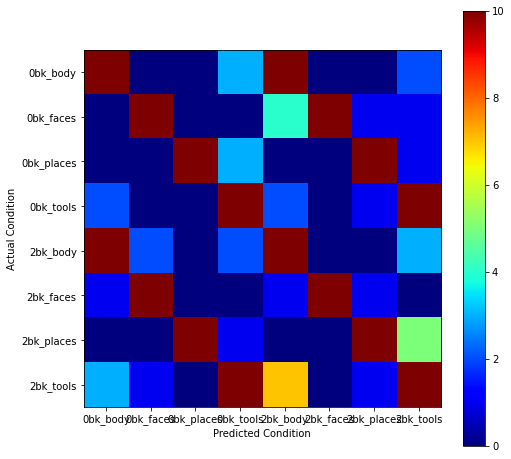

In [27]:
nroisV2 = sum(network_names == 'Visual2')
Accuracy_by_roiV2 = np.zeros(nroisV2)
for k in range(nroisV2): #looping over the networks
    z_T = np.transpose(z[network_names == 'Visual2',:])
    kf = KFold(n_splits = 5,shuffle = True)
    errors = 0
    predictions = np.zeros(np.shape(z_T)[0])
    probability = np.zeros((len(predictions),nconditions))
    for train_index, test_index in kf.split(z_T):
    #    print("TRAIN:", train_index, "TEST:", test_index)
        data_train = z_T[train_index]
        data_test = z_T[test_index]
        Label_train= condition_index[train_index] 
        Label_test = condition_index[test_index]
        lda = LDA(n_components=1)
        data_model = lda.fit(data_train, Label_train)
        predict = lda.predict(data_test)
        test = Label_test == predict
        errors = errors + sum(~test)
        predictions[test_index] = predict
        probability[test_index,:] = lda.predict_proba(data_test)
    errorrate = errors/len(condition_index)
    Accuracy_by_roiV2[k] = 100*(1-errorrate)

confusion_matrix = np.zeros((nconditions,nconditions))
for j in range(nconditions):
    values, counts = np.unique(predictions[condition_index == j],return_counts = True)
    confusion_matrix[j,values.astype(int)] = counts

plt.figure(figsize = (8,8))
plt.imshow(confusion_matrix,vmin = 0, vmax = 10, cmap = 'jet')
plt.xticks(range(8),labels = conditions)
plt.yticks(range(8),labels = conditions)
plt.xlabel('Predicted Condition')
plt.ylabel('Actual Condition')
plt.colorbar() 

#### **In this textbox, comment on the pattern of the confusion matrix results.  When there is an error, where does the misclassification occur?**

#### 4. Use LDA to make a classification model of all 8 experimental conditions, combining ROIs in the network identified in Question 3, with the network identified in Question 2 as best classifying task. Compute and visualize a confusion matrix for this new two-network model. As a comparison, compute a classification model using all the ROI from the whole brain.       

In [33]:
V2andF = len(network_names == 'Visual2' | 'Frontopariet')
Accuracy_by_V2andF = np.zeros(V2andF)

for k in range(V2andF): #looping over the networks
    z_T = np.transpose(z[network_names == 'Visual2'|'Frontopariet',:])
    kf = KFold(n_splits = 5,shuffle = True)
    errors = 0
    predictions = np.zeros(np.shape(z_T)[0])
    probability = np.zeros((len(predictions),nconditions))
    for train_index, test_index in kf.split(z_T):
    #    print("TRAIN:", train_index, "TEST:", test_index)
        data_train = z_T[train_index]
        data_test = z_T[test_index]
        Label_train= condition_index[train_index] 
        Label_test = condition_index[test_index]
        lda = LDA(n_components=1)
        data_model = lda.fit(data_train, Label_train)
        predict = lda.predict(data_test)
        test = Label_test == predict
        errors = errors + sum(~test)
        predictions[test_index] = predict
        probability[test_index,:] = lda.predict_proba(data_test)
    errorrate = errors/len(condition_index)
    Accuracy_by_V2andF[k] = 100*(1-errorrate)

confusion_matrix = np.zeros((nconditions,nconditions))
for j in range(nconditions):
    values, counts = np.unique(predictions[condition_index == j],return_counts = True)
    confusion_matrix[j,values.astype(int)] = counts
print(confusion_matrix)

TypeError: unsupported operand type(s) for |: 'str' and 'str'

#### **In this text box, comment on the difference in performance of the two-network classification model with the whole brain classification model. Does the two-network classification model show any systematic patterns in the confusion matrix, as compared to your answer in question 3**